In [1]:
import os
from ast import literal_eval

# Data analytics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Eval
from sklearn.metrics import (
    explained_variance_score,
    r2_score,
    mean_squared_error)

# Geospatial packages
import h3
import geopandas as gpd
from shapely import Point, Polygon
import esda
from mgwr.gwr import GWR
from libpysal.weights import Queen, lag_spatial
#from splot.esda import moran_scatterplot, lisa_cluster

# Modelo de GWR por año y elemento H3

## Carga de datos

In [2]:
# Ruta a archivos de datos
DATA_PATH = os.path.join(
    os.path.dirname(os.getcwd()),
    'data',
    'datos-produccion-maiz',
    'hist-maize-panel-rcp2p6.csv')

H3_CATALOGUE = os.path.join(
    os.path.dirname(os.getcwd()),
    'data',
    'datos-produccion-maiz',
    '01_h3_cells_catalogue.csv')

# Carga de datos
data = pd.read_csv(DATA_PATH)
cat_h3 = pd.read_csv(H3_CATALOGUE)
h3_res = 'hex_3'

# Unir resolución de malla a datos
data = (
    data
    .join(
        other=cat_h3[['id',h3_res]]
        ,on='id'
        ,how='left'
        ,rsuffix='__ignore')
    .drop(columns=['id','lon','lat','mean.precip.2','mean.temp.2','id__ignore'])
    .query("(year >= 2016) & (year <= 2019)")
    .groupby(by=['year', h3_res])
    .mean()
    .reset_index()
    .assign(
        coords = lambda df: df[h3_res].apply(lambda row: h3.cell_to_latlng(row)),))

data.columns = [col.replace('.','_') for col in data.columns]

data = data.assign(
    mean_precip_norm = lambda df: (df.mean_precip - df.mean_precip.mean()) / df.mean_precip.std(),
    mean_temp_norm = lambda df: (df.mean_temp - df.mean_temp.mean()) / df.mean_temp.std(),)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32840 entries, 0 to 32839
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              32840 non-null  int64  
 1   hex_3             32840 non-null  object 
 2   mean_precip       32840 non-null  float64
 3   mean_temp         32840 non-null  float64
 4   mean_yield        32840 non-null  float64
 5   coords            32840 non-null  object 
 6   mean_precip_norm  32840 non-null  float64
 7   mean_temp_norm    32840 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 2.0+ MB


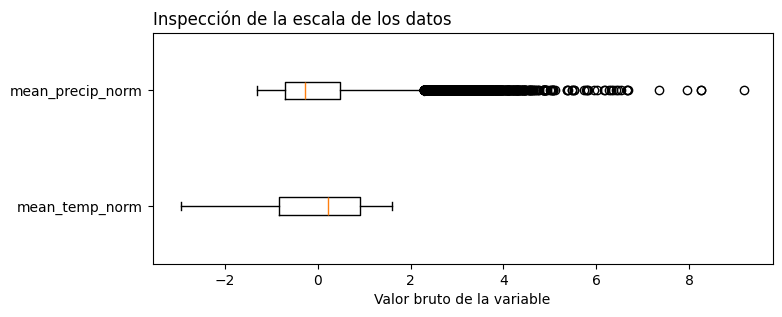

In [3]:
# Variables de visualización
vis_feats = ['mean_temp_norm','mean_precip_norm']

# Especificaciones de figura
fig, ax = plt.subplots(figsize=(8,3))

# Elementos de visualización
ax.boxplot(
    x=data.filter(items=vis_feats),
    vert=False)

# Anotaciones y estilo
ax.set_title('Inspección de la escala de los datos', loc='left')
ax.set_yticks(ticks=[1,2], labels=vis_feats)
ax.set_xlabel('Valor bruto de la variable')

plt.show()

Dada la diferencia en la escala de los datos, se aplicará algún tipo de estandarización a la variables de entrada al modelo

## Partición en Train y Test

In [4]:
# Definición de variable objetivo
target = 'mean_yield'

# Partición de conjuntos de datos
# Estructura de predictores
# 0: h3_res
# 1: mean_precip
# 2: mean_temp

x_train = (
    data
    .query("year <= 2018")
    .drop(columns=['year',target]))
    #.to_numpy())
y_train = (
    data
    .query("year <= 2018")
    .filter(items=[target]))
    #.to_numpy())

x_test = (
    data
    .query("year == 2019")
    .drop(columns=['year',target]))
    #.to_numpy())
y_test = (
    data
    .query("year == 2019")
    .filter(items=[target]))
    #.to_numpy())

print(
    f"""Datasets dimensions:
    x_train: {x_train.shape}
    y_train: {y_train.shape}
    x_test: {x_test.shape}
    y_test: {y_test.shape}""")

Datasets dimensions:
    x_train: (24630, 6)
    y_train: (24630, 1)
    x_test: (8210, 6)
    y_test: (8210, 1)


## Ingeniería de características

Primero se construye la cadena de transformaciones de los datos

## Geographicaly Weighted Regression

Entrenamiento de modelo

Tiempo de procesamiento: []

In [ ]:
band_widths = np.arange(4,61,2):
exp_var = []
coef_determ = []
rmse = []

features = ['mean_precip_norm','mean_temp_norm']
for bw in band_widths:
    print(bw)

    model = GWR(
        coords=np.vstack(x_train.coords.apply(lambda x: np.array(x)).to_numpy()),
        y=y_train.mean_yield.values.reshape((-1,1)),
        X=x_train[features].values,
        bw=bw,
        fixed=False,
        kernel='gaussian',
        constant=True,
        spherical=True)

    # Entrenamiento
    y_pred = model.predict(
        points=np.vstack(x_train.coords.apply(lambda x: np.array(x)).to_numpy()),
        P=x_train[features].values)

    var_score_train = explained_variance_score(
        y_true=y_train.mean_yield.values.reshape((-1,1)),
        y_pred=y_pred.predy)
    r2_train = r2_score(
        y_true=y_train.mean_yield.values.reshape((-1,1)),
        y_pred=y_pred.predy)
    rmse_train = mean_squared_error(
        y_true=y_train.mean_yield.values.reshape((-1,1)),
        y_pred=y_pred.predy)

    exp_var.append(var_score_train)
    coef_determ.append(r2_train)
    rmse.append(rmse_train)

4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60


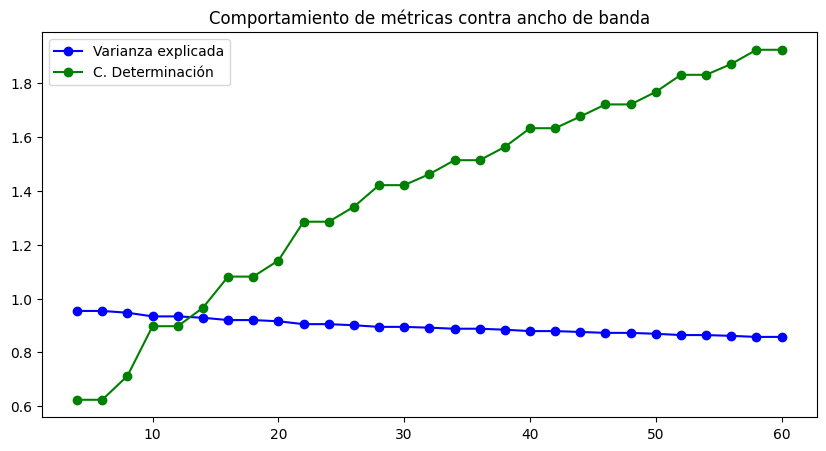

In [25]:
# Especificaciones de figura
fig, ax = plt.subplots(figsize=(10,5))

# Elementos de visualización
ax.plot(
    band_widths,
    exp_var,
    label='Varianza explicada',
    color='blue',
    marker='o')
# ax.plot(
#     band_widths,
#     coef_determ,
#     label='C. Determinación',
#     color='red',
#     marker='o')
ax.plot(
    band_widths,
    rmse,
    label='C. Determinación',
    color='green',
    marker='o')

# Anotaciones y estilo
ax.set_title("Comportamiento de métricas contra ancho de banda")
ax.legend()

plt.show()

In [ ]:
%%time
features = ['mean_precip_norm','mean_temp_norm']

# Iniciar instancia de modelo
model = GWR(
    coords=np.vstack(x_train.coords.apply(lambda x: np.array(x)).to_numpy()),
    y=y_train.mean_yield.values.reshape((-1,1)),
    X=x_train[features].values,
    bw=18,
    fixed=False,
    kernel='gaussian',
    constant=True,
    spherical=True)

# Entrenamiento
results = model.fit(lite=False)
results.summary()

Model type                                                         Gaussian
Number of observations:                                               24630
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         202091.456
Log-likelihood:                                                  -60868.516
AIC:                                                             121743.031
AICc:                                                            121745.033
BIC:                                                             -46929.884
R2:                                                                   0.390
Adj. R2:                                                              0.390

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

Otras métricas de desempeño dentro del conjunto de entramiento

In [10]:
results.aic

np.float64(75336.5040351189)

In [6]:
model = GWR(
    coords=np.vstack(x_train.coords.apply(lambda x: np.array(x)).to_numpy()),
    y=y_train.mean_yield.values.reshape((-1,1)),
    X=x_train[features].values,
    bw=18,
    fixed=False,
    kernel='gaussian',
    constant=True,
    spherical=True)

# Entrenamiento
y_pred = model.predict(
    points=np.vstack(x_train.coords.apply(lambda x: np.array(x)).to_numpy()),
    P=x_train[features].values)

In [7]:
var_score_train = explained_variance_score(
    y_true=y_train.mean_yield.values.reshape((-1,1)),
    y_pred=y_pred.predy)
r2_train = r2_score(
    y_true=y_train.mean_yield.values.reshape((-1,1)),
    y_pred=y_pred.predy)
rmse_train = mean_squared_error(
    y_true=y_train.mean_yield.values.reshape((-1,1)),
    y_pred=y_pred.predy)

print(
    f"""Métricas en train:
    varianza explicada: {100*var_score_train:.2f} %
    coef. determinación: {r2_train:.6f}
    RMSE: {np.sqrt(rmse_train):.6f}""")

Métricas en train:
    varianza explicada: 91.98 %
    coef. determinación: 0.919595
    RMSE: 1.039921


## Desempeño en conjunto de Prueba

In [43]:
model = GWR(
    coords=np.vstack(x_train.coords.apply(lambda x: np.array(x)).to_numpy()),
    y=y_train.mean_yield.values.reshape((-1,1)),
    X=x_train[features].values,
    bw=18+12+6,
    fixed=False,
    kernel='gaussian',
    constant=True,
    spherical=True)

y_pred = model.predict(
    points=np.vstack(x_test.coords.apply(lambda x: np.array(x)).to_numpy()),
    P=x_test[features].values)

In [44]:
var_score_val = explained_variance_score(
    y_true=y_test.mean_yield.values.reshape((-1,1)),
    y_pred=y_pred.predy)
r2_val = r2_score(
    y_true=y_test.mean_yield.values.reshape((-1,1)),
    y_pred=y_pred.predy)
rmse_val = mean_squared_error(
    y_true=y_test.mean_yield.values.reshape((-1,1)),
    y_pred=y_pred.predy)

print(
    f"""Métricas en train:
    varianza explicada: {100*var_score_val:.2f} %
    coef. determinación: {r2_val:.6f}
    RMSE: {np.sqrt(rmse_val):.6f}""")

Métricas en train:
    varianza explicada: 77.15 %
    coef. determinación: 0.767278
    RMSE: 1.698391


## Normalidad geoespacial de residuales

### Datos expandidos

In [45]:
out_path = os.path.join(
    '..','data',
    'models_output',
    '02_gwr.csv')

In [46]:
residual_test = (
    data
    .query("year == 2019")
    .assign(
        mean_yield_pred = y_pred.predy.flatten(),
        residuals = lambda df: df.mean_yield_pred - df.mean_yield))

residual_test.to_csv(out_path, index=False)

Carga de datos expandidos leyendo el archivo de salida del modelo

In [47]:
# Carga de datos expandidos
residual_test = pd.read_csv(out_path)
residual_test.head()

,year,hex_3,mean_precip,mean_temp,mean_yield,coords,mean_precip_norm,mean_temp_norm,mean_yield_pred,residuals
0,2019,830830fffffffff,136.512866,7.503748,5.291118,"(63.452796548421794, 6.880273103370711)",0.653357,-1.172926,5.241603,-0.049515
1,2019,830833fffffffff,112.218055,7.974006,4.755333,"(63.33354485544912, 8.78279539331972)",0.305499,-1.120801,5.198486,0.443153
2,2019,830880fffffffff,55.103881,7.570549,5.866617,"(60.191218048618175, 18.258530119185007)",-0.512274,-1.165521,4.346540,-1.520077
3,2019,830882fffffffff,44.416754,8.394179,5.053000,"(59.46670267715353, 19.25232907365805)",-0.665295,-1.074229,4.129709,-0.923291
4,2019,830883fffffffff,65.744323,9.267750,4.921000,"(60.216732668856956, 20.268815423927144)",-0.359922,-0.977401,5.091939,0.170939


In [48]:
def get_h3_polygon(row:str):
    points = h3.cell_to_boundary(
        h=row
        ,geo_json=True)

    return Polygon(points)

In [49]:
# Carga de datos expandidos
residual_test = pd.read_csv(out_path)

# Definir columna de geometría
geometry = gpd.GeoSeries(
    data=residual_test[h3_res].apply(func=get_h3_polygon))

# Conversión a GeoPandas
residual_test = gpd.GeoDataFrame(data=residual_test, geometry=geometry)

# Asignar CRS
residual_test.crs = 'EPSG:4326'

residual_test.head()

,year,hex_3,mean_precip,mean_temp,mean_yield,coords,mean_precip_norm,mean_temp_norm,mean_yield_pred,residuals,geometry
0,2019,830830fffffffff,136.512866,7.503748,5.291118,"(63.452796548421794, 6.880273103370711)",0.653357,-1.172926,5.241603,-0.049515,"POLYGON ((6.7913 63.96438, 5.86142 63.76021, 5..."
1,2019,830833fffffffff,112.218055,7.974006,4.755333,"(63.33354485544912, 8.78279539331972)",0.305499,-1.120801,5.198486,0.443153,"POLYGON ((8.7221 63.84278, 7.79997 63.65181, 7..."
2,2019,830880fffffffff,55.103881,7.570549,5.866617,"(60.191218048618175, 18.258530119185007)",-0.512274,-1.165521,4.346540,-1.520077,"POLYGON ((17.25045 60.41134, 17.26259 59.92157..."
3,2019,830882fffffffff,44.416754,8.394179,5.053000,"(59.46670267715353, 19.25232907365805)",-0.665295,-1.074229,4.129709,-0.923291,"POLYGON ((18.26105 59.69862, 18.26353 59.20079..."
4,2019,830883fffffffff,65.744323,9.267750,4.921000,"(60.216732668856956, 20.268815423927144)",-0.359922,-0.977401,5.091939,0.170939,"POLYGON ((19.26639 60.45218, 19.25929 59.96206..."


### Rezago espacial

Primero se define la matriz de pesos utilizando el criterio de contigüidad kNN dado que son puntos de coordenadas

In [50]:
# Matriz de pesos espaciales
W = Queen.from_dataframe(
    df=residual_test,
    geom_col='geometry',
    silence_warnings=True)
# W = KNN.from_dataframe(
#     df=residual_test,
#     k=10,
#     geom_col='geometry',)

# Estandarizar por renglón los pesos
W.set_transform(value='R')

C:\Users\Miguel\AppData\Local\Temp\ipykernel_25640\4031955565.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  W = Queen.from_dataframe(


Ahora se calcula el rezago espacial con respecto a la variable objetivo

In [51]:
residual_test['residuals_spatial_lag'] = lag_spatial(
    w=W,
    y=residual_test.residuals)

Finalmente, se visualiza la dispersión de Moran

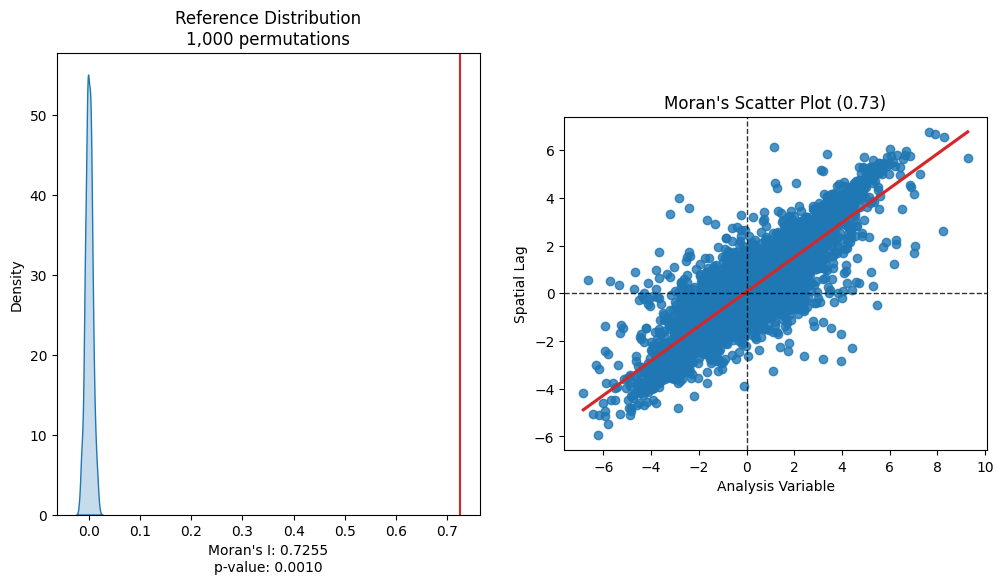

In [52]:
# Moran's I statistic instance
morans_stat = esda.moran.Moran(
    y=residual_test.residuals
    ,w=W
    ,transformation='R'
    ,permutations=1_000)

# Figure specs
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# Visualization elements
sns.kdeplot(
    data=morans_stat.sim
    ,fill=True
    ,ax=ax[0])
ax[0].axvline(x=morans_stat.I, color='tab:red')
sns.regplot(
    data=residual_test
    ,x='residuals'
    ,y='residuals_spatial_lag'
    ,ci=None
    ,line_kws=dict(color='tab:red')
    ,ax=ax[1])
ax[1].axvline(0, color='black', alpha=0.8, linewidth=1, linestyle='--')
ax[1].axhline(0, color='black', alpha=0.8, linewidth=1, linestyle='--')


# Styling
ax[0].set(
    title=f'Reference Distribution\n{morans_stat.permutations:,} permutations'
    ,xlabel=f"Moran's I: {morans_stat.I:.4f}\np-value: {morans_stat.p_sim:.4f}"
    ,ylabel='Density')
ax[1].set(
    title=f"Moran's Scatter Plot ({morans_stat.I:.2f})"
    ,xlabel='Analysis Variable'
    ,ylabel='Spatial Lag')
ax[1].set_aspect('equal')

plt.show()

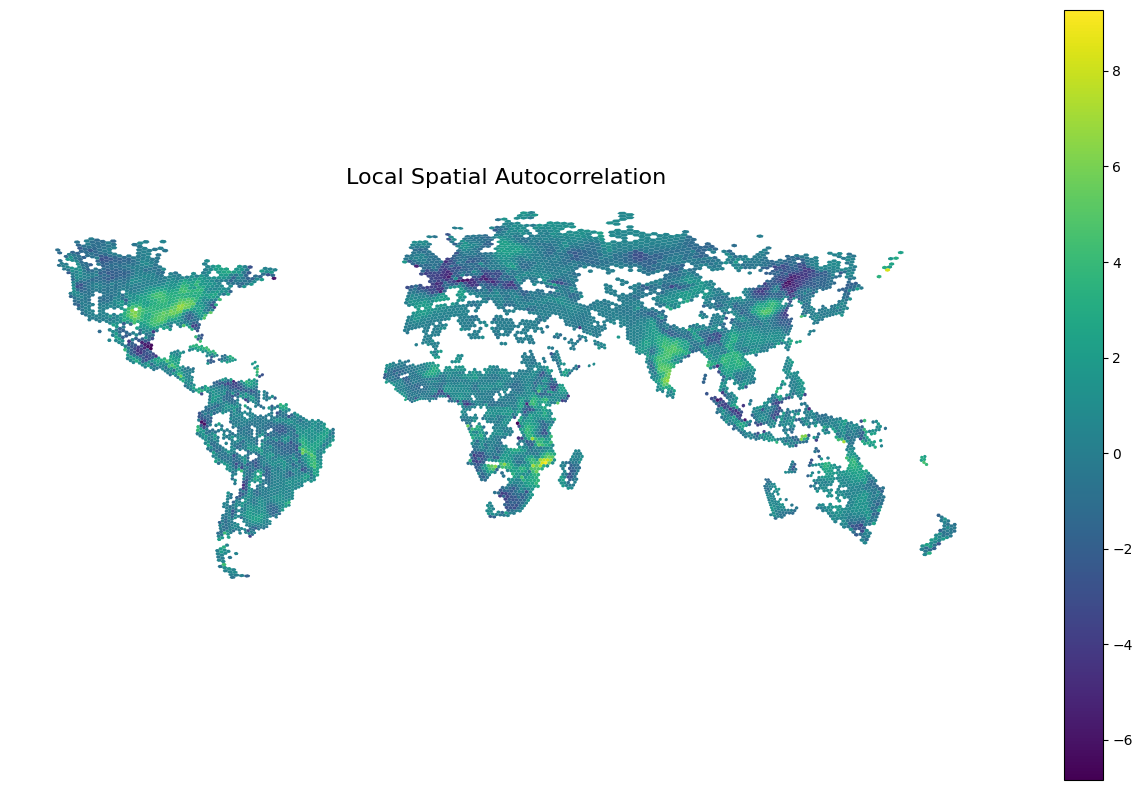

In [53]:
# Figure specs
fig, ax = plt.subplots(figsize=(16,10))

# Visualization elements
residual_test.plot(
    column='residuals'
    ,legend=True
    ,ax=ax)

# Styling
ax.set_title(
    label='Local Spatial Autocorrelation'
    ,fontsize=16)
ax.set_yticks([])
ax.set_xticks([])
ax.set_frame_on(False)

plt.show()